In [1]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
%matplotlib inline

# Optimisation

Optimisation plays an important role in the efficient of how a Neural Network is trained. Choosing an efficient and effective optimisation algorithm is especially important as Networks often work in the regimes of Big Data where they strives most. In this script, I will be covering the different techniques often used by practitioners.

1. Mini-batch Gradient Descent
2. Momentum
3. RMSProp
4. Adam
5. Learning Rate Decay

# Generate data

In [15]:
from sklearn.datasets import make_regression

In [22]:
x, y = make_regression(n_samples=10000,
                       n_features=8,
                       n_informative=6,
                       n_targets=1,
                       noise=0.2
                      )

In [23]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [24]:
# split to train & validation set
split = int(0.9 * 10000)
x_train = x[:split]
x_val = x[split:]
y_train = y[:split]
y_val = y[split:]

# Mini-batch GD

We use mini-batch gradient descent when we encounter datasets that are very large. This is because, as the datasets get larger, the Network have to run through a larger number of examples before updating the weights once (taking a step) given the traditional batch gradient descent. This is not ideal as it results in a much slower learning rate. As such, mini-batch would simply means breaking the dataset down into smaller-sized batches, feeding them into the network and updating the weights each time. Now, running the network through the entire dataset would result in multiple steps which could improve training speeds.

The tricky part is finding a balance in the mini-batch size. On 1 end, if we use a batch GD (all examples), we face the issue of taking steps infrequently. On the other end, if update our weights after each example (stochastic GD), we give up efficiency from vectorisation. As such, using a batch-size somewhere in the centre would be ideal. Some common mini-batch sizes are 64, 128 or 256.

In [ ]:
def mini_batch_training(nn_model, batch_size, epochs):
    # Training the Network
    loss = []
    val_loss = []

    for e in range(epochs):

        permutation = torch.randperm(x_train.size()[0]) # random permutation to group batches differently

        for i in range(0, x_train.size()[0], batch_size):
            optimiser.zero_grad() # zero out any pre-computed gradients

            # assign batch
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()

            output = nn_model(batch_x) # forward prop
            run_loss = criterion(output, batch_y) # compute loss
            loss.append(run_loss.item()/batch_x.size()[0]) # store loss
            run_loss.backward() # backprop - calculate gradients
            optimiser.step() # update weights

        permutation = torch.randperm(x_val.size()[0]) # random permutation to group batches differently

        for i in range(0, x_val.size()[0], batch_size):

            # assign batch
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()

            output = nn_model(batch_x)
            run_loss = criterion(output, batch_y)
            val_loss.append(run_loss.item()/batch_x.size()[0])
            
    # plot training and validation loss over training
    plt.figure(figsize=[20,10])
    plt.plot(range(len(loss)), loss)
    plt.show()
    plt.figure(figsize=[20,10])
    plt.plot(range(len(val_loss)), val_loss)
    plt.show()

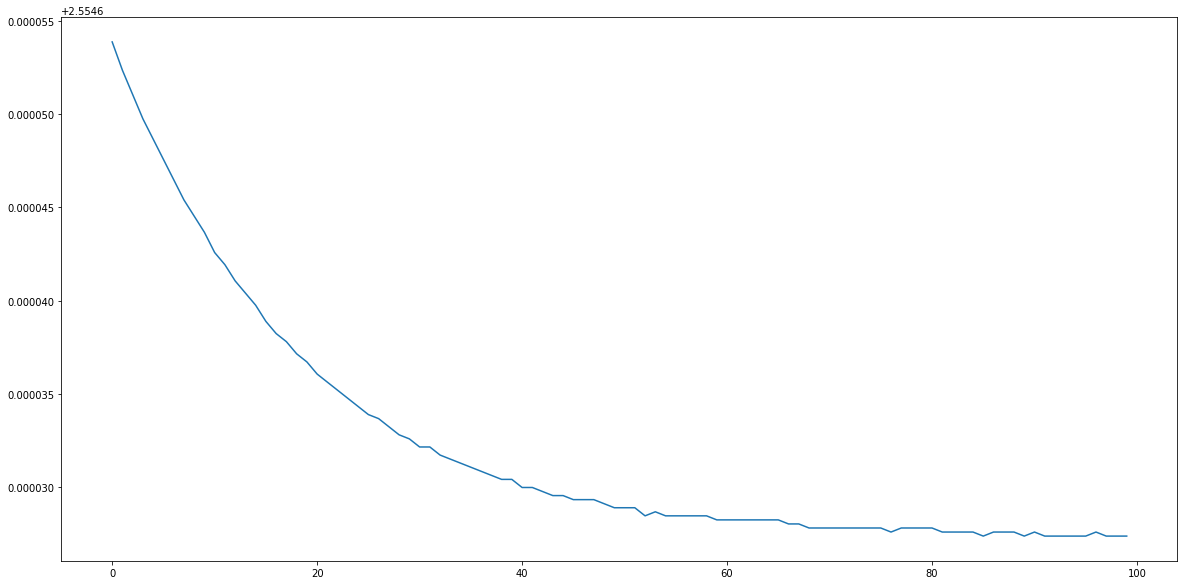

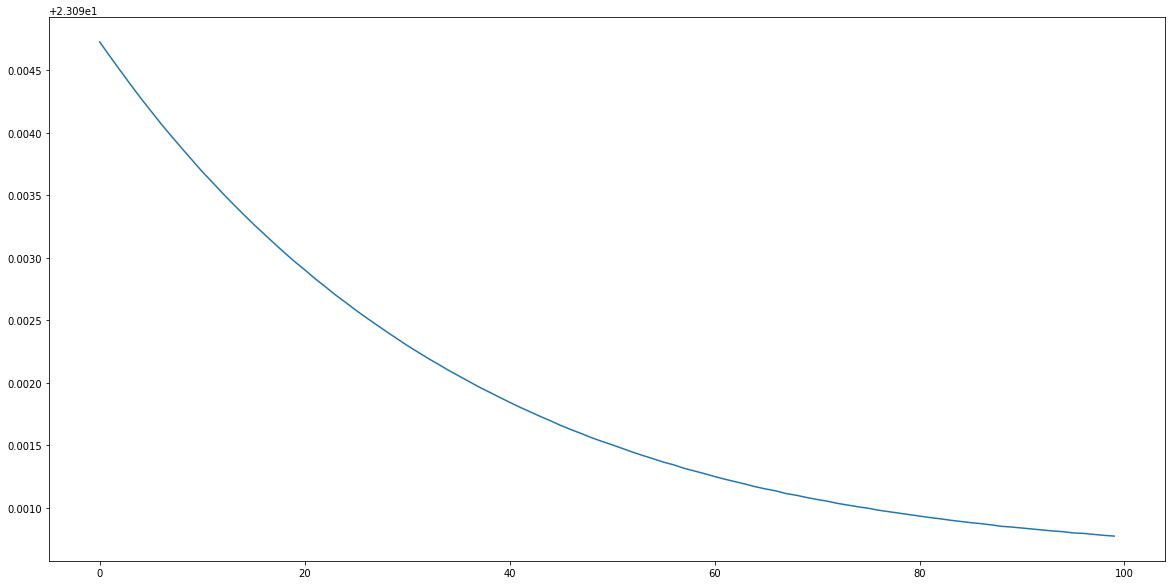

CPU times: user 2.27 s, sys: 32 ms, total: 2.3 s
Wall time: 815 ms


In [28]:
%%time
# Network architecture
nn_model = nn.Sequential(
    nn.Linear(8, 32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# move model & dataset to gpu
nn_model = nn_model.cuda()

# loss & optimiser
criterion = nn.MSELoss()
optimiser = optim.SGD(nn_model.parameters(), lr =0.01)

# Batch GD (full dataset)
mini_batch_training(nn_model, batch_size=10000, epochs=100)

/home/brandon/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


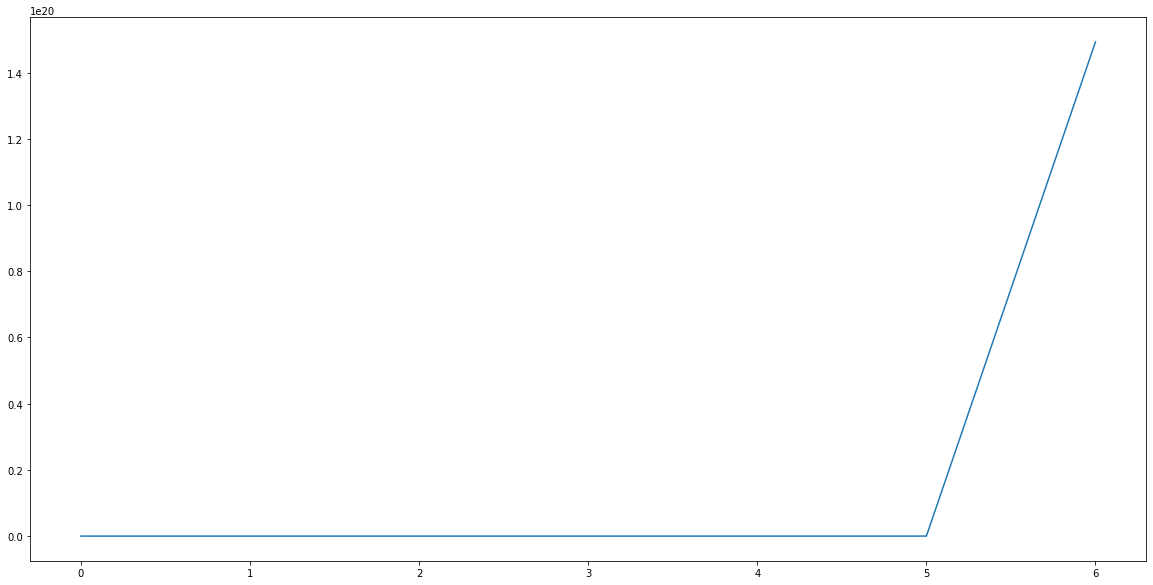

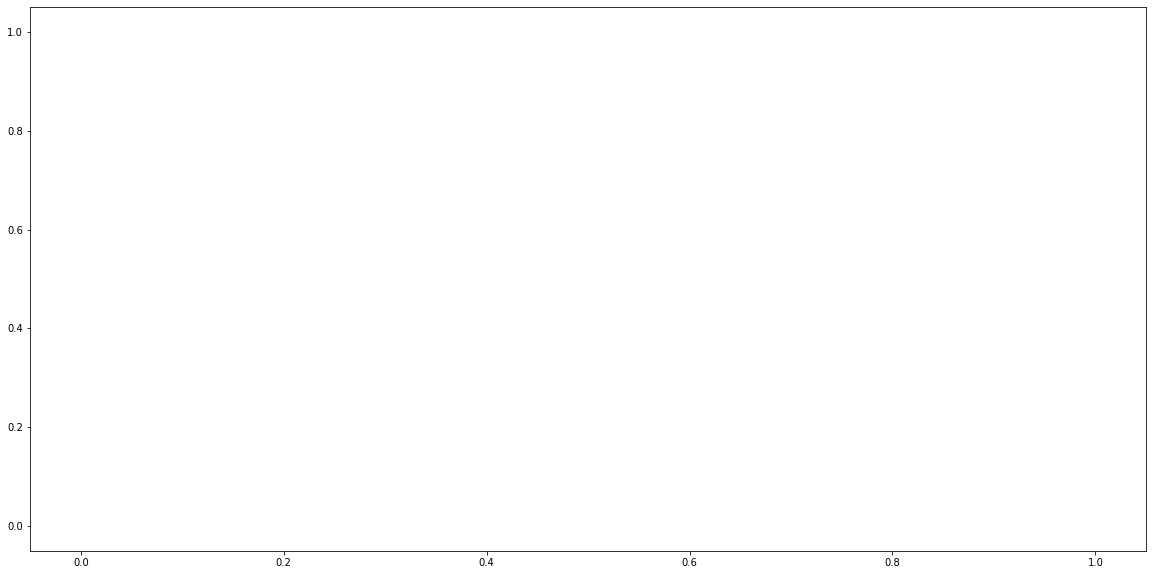

CPU times: user 15min 9s, sys: 10.3 s, total: 15min 19s
Wall time: 15min 14s


In [27]:
%%time
# Network architecture
nn_model = nn.Sequential(
    nn.Linear(8, 32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# move model & dataset to gpu
nn_model = nn_model.cuda()

# loss & optimiser
criterion = nn.MSELoss()
optimiser = optim.SGD(nn_model.parameters(), lr =0.01)

# Stochastic GD ( dataset)
mini_batch_training(nn_model, batch_size=1, epochs=100)

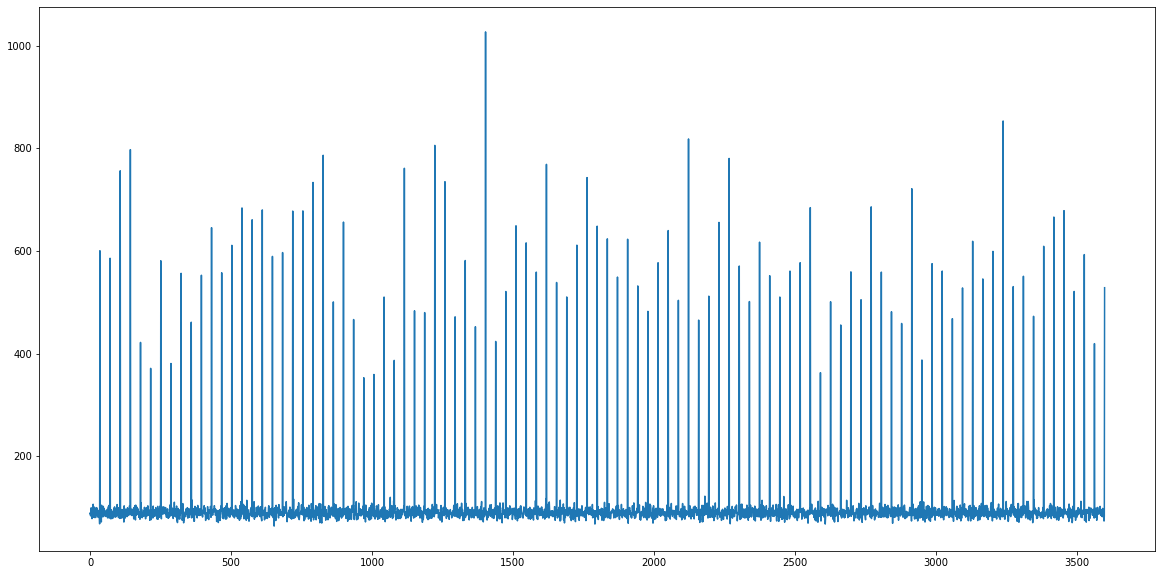

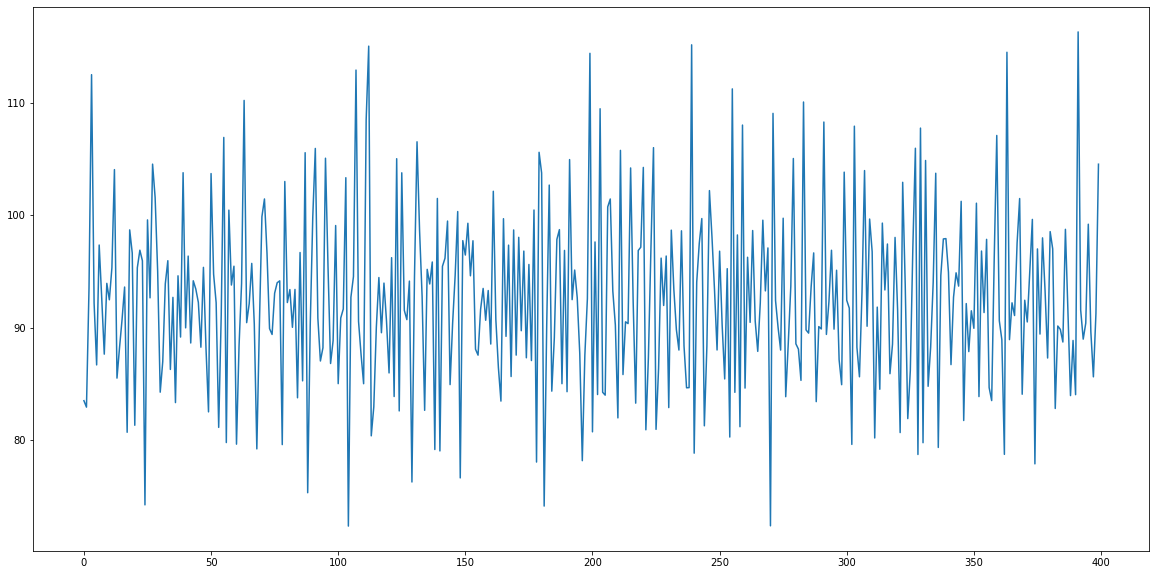

CPU times: user 4.21 s, sys: 36 ms, total: 4.25 s
Wall time: 4.25 s


In [39]:
%%time
# Network architecture
nn_model = nn.Sequential(
    nn.Linear(8, 32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# move model & dataset to gpu
nn_model = nn_model.cuda()

# loss & optimiser
criterion = nn.MSELoss()
optimiser = optim.SGD(nn_model.parameters(), lr=0.01)

# Stochastic GD ( dataset)
mini_batch_training(nn_model, batch_size=256, epochs=100)

# Momentum

The idea behind momentum is computing an Exponential Weighted Average of our gradients and use that to update our weights instead. Imagining the cost function space, the Network often learns in a osciallating fashion when the network converges towards the minima. Given this osciallating behaviour, if we want to speed learning up, we want to maximise our moves in the direction of the minima and minimise those that are perpendicular to it.

By taking an exponential weighted average of the past gradients, we create 2 effects. Firstly, that oscillations that are perpendicular to the direction will get cancelled out. Secondly, since all the gradients are pointing towards the direction of the minima, this gets amplified.

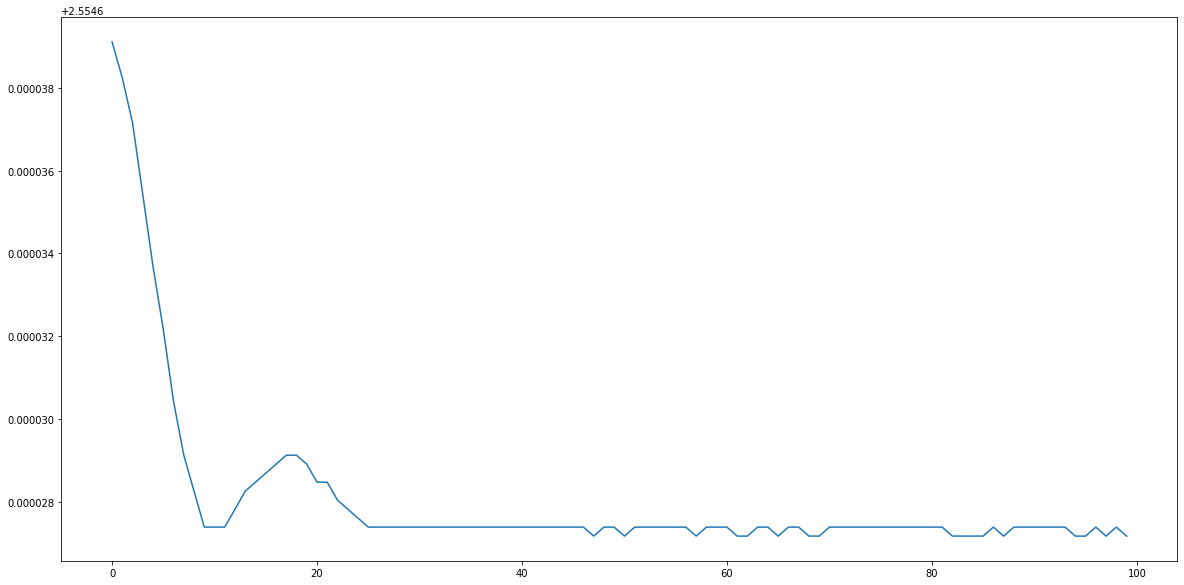

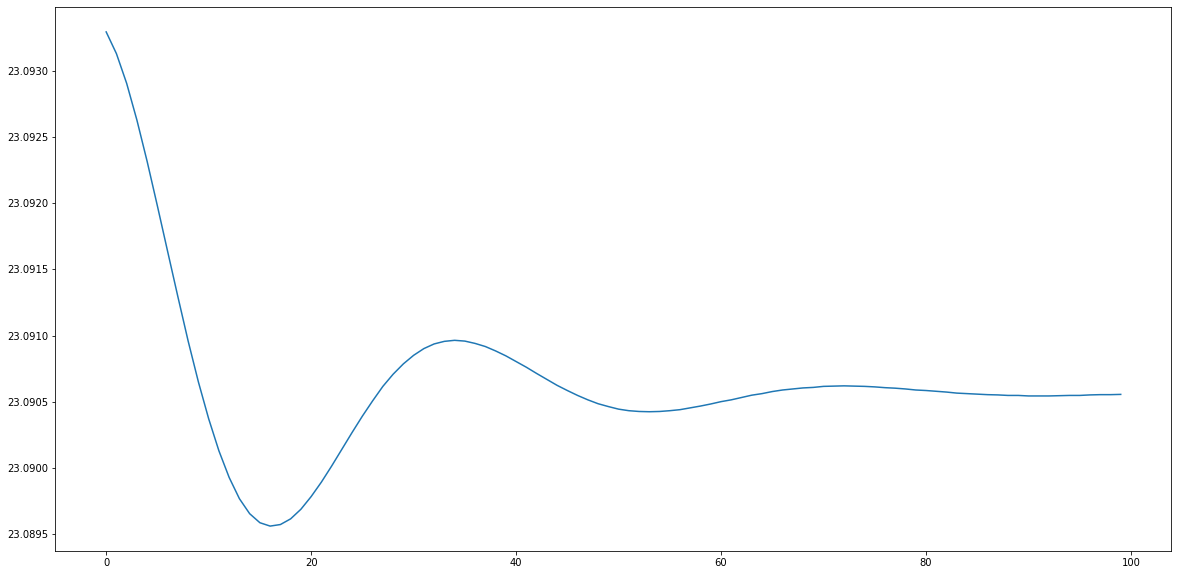

CPU times: user 2.3 s, sys: 48.3 ms, total: 2.35 s
Wall time: 849 ms


In [40]:
%%time
# Network architecture
nn_model = nn.Sequential(
    nn.Linear(8, 32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# move model & dataset to gpu
nn_model = nn_model.cuda()

# loss & optimiser
criterion = nn.MSELoss()
optimiser = optim.SGD(nn_model.parameters(), lr =0.01, momentum=0.9)

# Stochastic GD ( dataset)
mini_batch_training(nn_model, batch_size=10000, epochs=100)

# RMSProp

RMSProp stands for Root Mean Square Prop. RMSprop is very similar to Momentum but instead, we square the gradients. i.e. we take the Exponential Weighted Average of the squared derivatives. The idea behind it is similar to momentum.

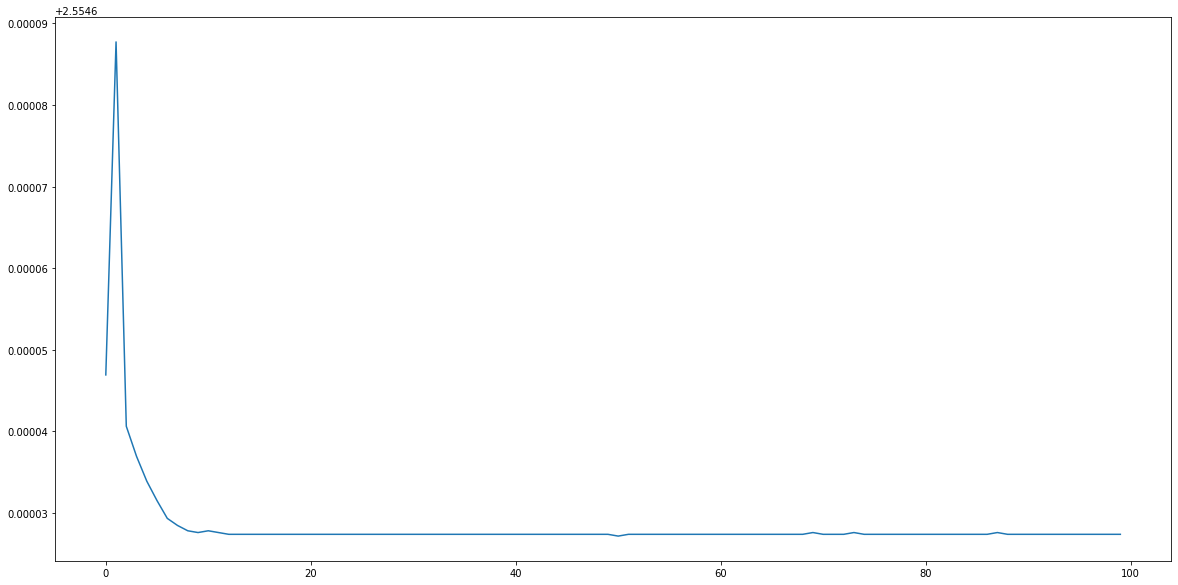

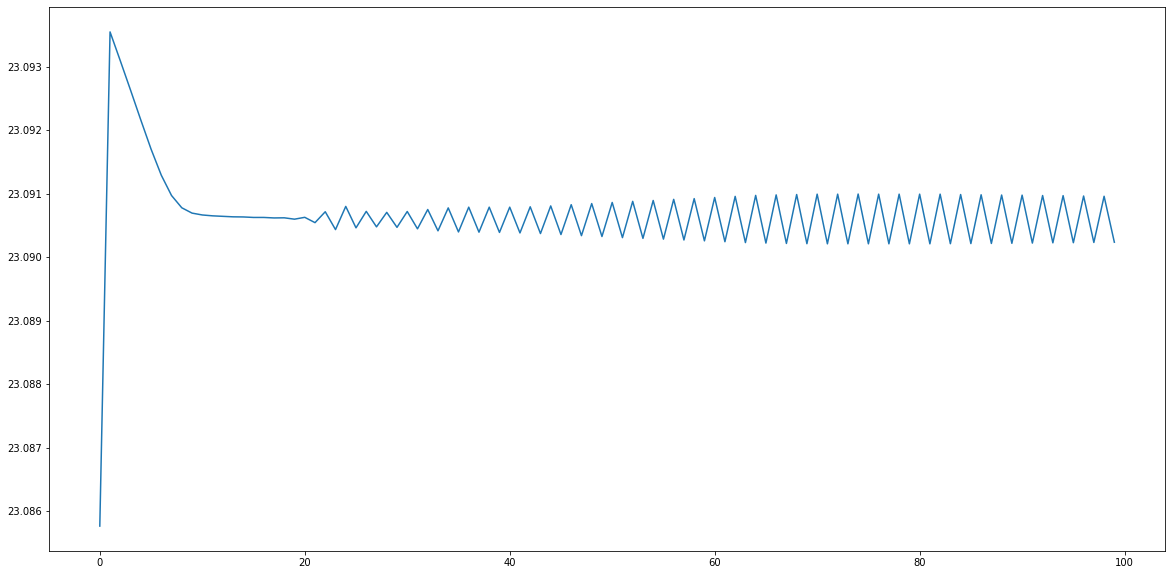

CPU times: user 2.23 s, sys: 36.3 ms, total: 2.26 s
Wall time: 782 ms


In [44]:
%%time
# Network architecture
nn_model = nn.Sequential(
    nn.Linear(8, 32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# move model & dataset to gpu
nn_model = nn_model.cuda()

# loss & optimiser
criterion = nn.MSELoss()
optimiser = optim.RMSprop(nn_model.parameters(), lr =0.01, alpha=0.95)

# Stochastic GD ( dataset)
mini_batch_training(nn_model, batch_size=10000, epochs=100)

# Adam

A combination of RMSprop and Momentum. Currently, Adam is known as the golden standard for optimisation algorithm for NN.

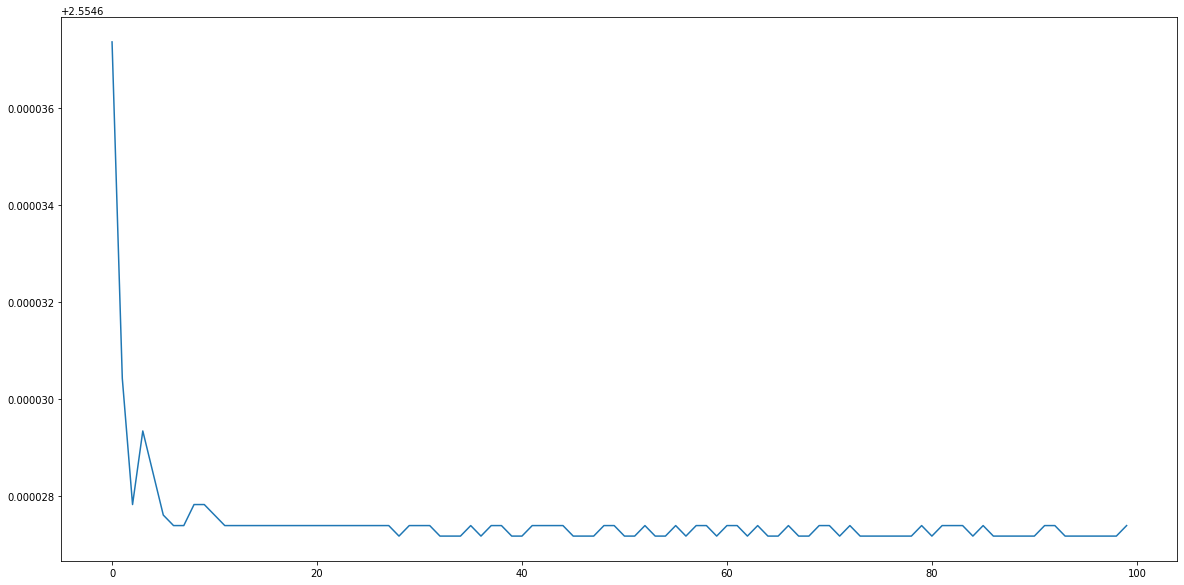

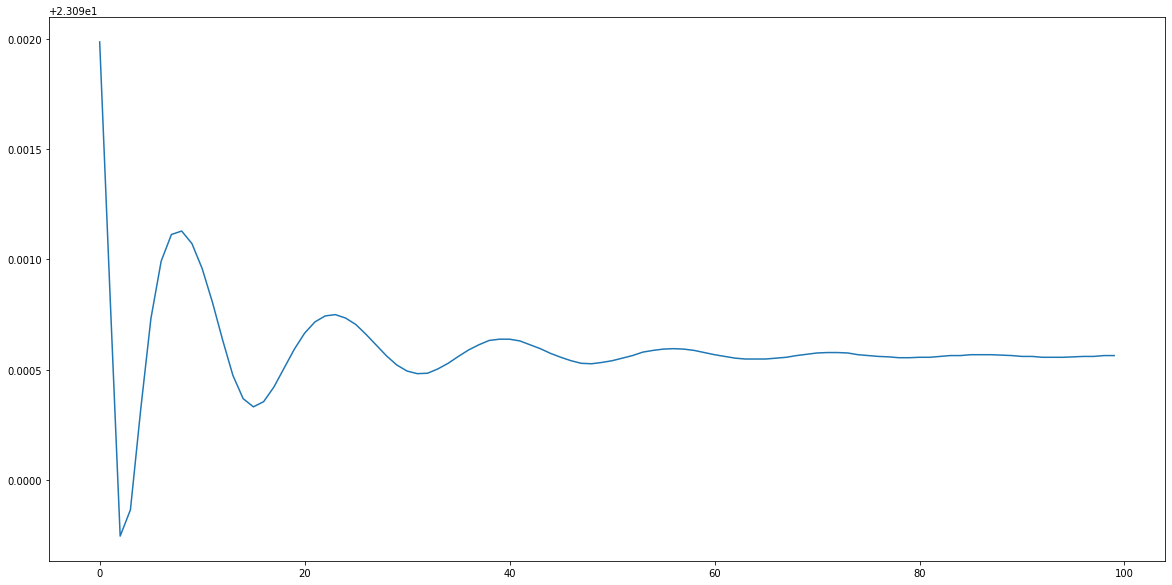

CPU times: user 2.29 s, sys: 40.2 ms, total: 2.33 s
Wall time: 808 ms


In [45]:
%%time
# Network architecture
nn_model = nn.Sequential(
    nn.Linear(8, 32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# move model & dataset to gpu
nn_model = nn_model.cuda()

# loss & optimiser
criterion = nn.MSELoss()
optimiser = optim.Adam(nn_model.parameters(), lr =0.01, betas=(0.9, 0.999))

# Stochastic GD ( dataset)
mini_batch_training(nn_model, batch_size=10000, epochs=100)